In [1]:
from bs4 import BeautifulSoup
import numpy as np, seaborn as sns, matplotlib.pyplot as plt, warnings, time, requests, pandas as pd
warnings.filterwarnings("ignore")
from google.colab import output

In [27]:
ids = pd.read_csv('https://raw.githubusercontent.com/fmathews11/College_Basketball_Functions/main/ids.csv')
convert_dict = {'MIN':int,
               'OREB':int,
               'DREB':int,
               'REB':int,
               'AST':int,
               'STL':int,
               'BLK':int,
               'TO':int,
               'PF':int,
               'PTS':int,
               'FGM':int,
               'FGA':int,
               '3PM':int,
               '3PA':int,
               'FTM':int,
               'FTA':int}
col_order = ['Player',
                 'PTS',
                 'MIN',
                 'FGM',
                 'FGA',
                 '3PM',
                 '3PA',
                 'FTM',
                 'FTA',
                 'OREB',
                 'DREB',
                 'REB',
                 'AST',
                 'STL',
                 'BLK',
                 'TO',
                 'PF',
                 'Position']

def calculate_possessions(fga,orebs,tos,fta):
    value = (fga-orebs) + tos + (0.475*fta)
    return value

def clean_up_boxscore(df):
    df = df.iloc[:len(df)-2,]
    df['Position'] = [i[-1] for i in df.Starters]
    df = df.infer_objects()
    df.Starters = [i[:int((len(i)-1)/2)] for i in df.Starters]
    df['FGM'] = [i[0] for i in df.FG.str.split('-')]
    df['FGA'] = [i[1] for i in df.FG.str.split('-')]
    df['3PM'] = [i[0] for i in df['3PT'].str.split('-')]
    df['3PA'] = [i[1] for i in df['3PT'].str.split('-')]
    df['FTM'] = [i[0] for i in df.FT.str.split('-')]
    df['FTA'] = [i[1] for i in df.FT.str.split('-')]
    if type(df.MIN[0]) == str:
      df.MIN = 0
    df = df.astype(convert_dict)
    df = df.append(df.sum(numeric_only = True),ignore_index = True)
    last_row = len(df) - 1
    df = df.rename(columns = {"Starters":"Player"})
    df = df[col_order]
    df.iloc[last_row,0] = 'Team'
    df.iloc[last_row,17] = ""
    return df.astype(convert_dict)

def get_boxscores(game_id,disp = False):

  #Create the URL and pull in the HTML
  url = 'https://www.espn.com/mens-college-basketball/boxscore/_/gameId/'+str(game_id)
  r = requests.get(url)
  soup = BeautifulSoup(r.content,'lxml')

  #Isolate the home team, away team, and game date.  Away team is always first
  away_team = str(soup.find('title')).split('-')[0].replace("<title>","").strip().split(' vs. ')[0]
  home_team = str(soup.find('title')).split('-')[0].replace("<title>","").strip().split(' vs. ')[1]
  game_date = str(soup.find("title")).split("-")[2].strip()

  #Infer tables with Pandas
  dfs = pd.read_html(url)
  #Away team is always index value 1, home team is 2
  away_team_df = dfs[1]
  home_team_df = dfs[2]
  # Convert columns from tuples to strings
  if type(away_team_df.columns[0]) is tuple:
    away_team_df.columns = [i[0] for i in away_team_df.columns.tolist()]
  if type(home_team_df.columns[0]) is tuple:
    home_team_df.columns = [i[0] for i in home_team_df.columns.tolist()]

  #Clean the dataframes
  away_team_df = clean_up_boxscore(away_team_df)
  home_team_df = clean_up_boxscore(home_team_df)
  #Create outer index
  away_team_df = pd.concat({away_team:away_team_df})
  home_team_df = pd.concat({home_team:home_team_df})

  if disp:
    display(away_team_df,home_team_df)
  else:
    return away_team_df,home_team_df

def get_agg_boxscore(game_id,disp = True):
    df_away,df_home = get_boxscores(game_id)
    away_team = df_away.index[0][0]
    home_team = df_home.index[0][0]
    last_row = len(df_away)
    df_away = df_away.iloc[last_row-1:]
    df_away = df_away[["PTS",
          "FGM",
          "FGA",
          "3PM",
          "3PA",
          "FTM",
          "FTA",
          "OREB",
          "DREB",
          "TO"]].reset_index().drop('level_1',1).rename(columns = {'level_0':'Team'}).set_index("Team")

    last_row = len(df_home)
    df_home = df_home.iloc[last_row-1:]
    df_home = df_home[["PTS",
          "FGM",
          "FGA",
          "3PM",
          "3PA",
          "FTM",
          "FTA",
          "OREB",
          "DREB",
          "TO"]].reset_index().drop('level_1',1).rename(columns = {'level_0':'Team'}).set_index("Team")
    final_df = pd.concat([df_away,df_home])

    final_df['POS'] = round(final_df.apply(lambda x: calculate_possessions(x.FGA,x.OREB,x.TO,x.FTA),axis = 1),0).astype(int)
    final_df['PTS_POS'] = round(final_df.PTS / final_df.POS,2)
    final_df['3PT%'] = round(final_df['3PM'] / final_df['3PA'],2)
    away_defensive_rebounds = final_df[final_df.index == away_team].DREB.item()
    home_defensive_rebounds = final_df[final_df.index == home_team].DREB.item()
    if final_df.loc[final_df.index == home_team].OREB.item() > 0 and final_df.loc[final_df.index == away_team].OREB.item() > 0:
      home_team_or = (final_df.loc[final_df.index == home_team].OREB.item())/(final_df.loc[final_df.index == home_team].OREB.item() + away_defensive_rebounds)
      away_team_or = (final_df.loc[final_df.index == away_team].OREB.item())/(final_df.loc[final_df.index == away_team].OREB.item() + home_defensive_rebounds)
      final_df['OR%'] = [round(away_team_or,2),round(home_team_or,2)]
    final_df['FG%'] = round(final_df.FGM/final_df.FGA,2)
    final_df["TS%"] = round(100*final_df.PTS/(2*(final_df.FGA + 0.475*final_df.FTA)),2)
    final_df['TO%'] = round(100*(final_df.TO/final_df.POS),2)
    type_dict = {'PTS':int,
                  'FGM':int,
                  'FGM':int,
                '3PM':int,
                '3PA':int,
                'FTM':int,
                'FTA':int,
                'OREB':int,
                'DREB':int,
                'TO':int,
                'POS':int}
    if disp:
      display(final_df.rename_axis("").astype(object).transpose())

    return final_df.astype(type_dict)

In [26]:
get_boxscores(401364432,disp = True)

Player  PTS  MIN  FGM  FGA  ...  STL  BLK  TO  PF  Position
Illinois 0          K. Cockburn    6    0    3    4  ...    0    0   0   2         C
         1           A. Plummer   14    0    5    7  ...    0    0   0   1         G
         2         J. Grandison    5    0    2    3  ...    0    0   1   2         G
         3          D. Williams    3    0    1    4  ...    1    1   0   0         G
         4           T. Frazier    0    0    0    5  ...    0    0   2   1         G
         5   B. Bosmans-Verdonk    0    0    0    1  ...    0    0   0   1         F
         6           C. Hawkins    0    0    0    0  ...    0    0   0   1         F
         7             O. Payne    1    0    0    0  ...    0    0   0   1         F
         8          R. Melendez    0    0    0    0  ...    0    0   1   2         G
         9           A. Curbelo    9    0    3    6  ...    1    0   2   1         G
         10                Team   38    0   14   30  ...    2    1   6  12          

[11 rows x 18 columns]

Player  PTS  MIN  FGM  FGA  ...  STL  BLK  TO  PF  Position
Purdue 0      M. Gillis    6    0    2    2  ...    0    0   1   0         F
       1        Z. Edey    4    0    2    4  ...    0    1   1   2         C
       2        J. Ivey    4    0    1    5  ...    0    0   1   1         G
       3  E. Hunter Jr.    0    0    0    3  ...    0    0   1   0         G
       4  S. Stefanovic    2    0    1    5  ...    1    0   0   0         G
       5       C. Furst    5    0    1    3  ...    0    0   0   2         F
       6    T. Williams   10    0    2    6  ...    1    1   2   2         F
       7      E. Morton    5    0    2    2  ...    0    0   0   0         G
       8    I. Thompson    0    0    0    0  ...    0    0   0   1         G
       9           Team   36    0   11   30  ...    2    2   6   8          

[10 rows x 18 columns]

In [39]:
pd.read_html(url)

[  Unnamed: 0   1   2   T
 0        ILL  38  30  68
 1        PUR  36  48  84,
       time  team                                   PLAY    SCORE  Unnamed: 4
 0    20:00   NaN                Jump Ball won by Purdue    0 - 0         NaN
 1    19:41   NaN  Jaden Ivey missed Three Point Jumper.    0 - 0         NaN
 2    19:41   NaN   Da'Monte Williams Defensive Rebound.    0 - 0         NaN
 3    19:15   NaN             Kofi Cockburn made Jumper.    2 - 0         NaN
 4    18:56   NaN                 Zach Edey made Jumper.    2 - 2         NaN
 ..     ...   ...                                    ...      ...         ...
 158   0:06   NaN                 Foul on Trent Frazier.  36 - 34         NaN
 159   0:06   NaN            Jaden Ivey made Free Throw.  36 - 35         NaN
 160   0:06   NaN            Jaden Ivey made Free Throw.  36 - 36         NaN
 161   0:01   NaN              Andre Curbelo made Layup.  38 - 36         NaN
 162   0:00   NaN                        End of 1st half  38 - 

In [4]:
#test_df = None
last_reported_time = 0

In [28]:
i = 0
n_iter = 50
url = "https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/"
game_id = 401364432
half = 2
url = url + str(game_id)
stop_value = 0
while i <= n_iter:
  print(f"Iteration number {i} of {n_iter}")
  print(f"Retry number {stop_value} of 10")
  df = pd.read_html(url)[1]
  if df.SCORE.str.contains('0').any():
    half = 1
  current_time = df.iloc[0,0]
  if current_time != last_reported_time:
    stop_value = 0
    output.clear()
    print(i)
    temp_df = get_agg_boxscore(game_id,disp = True)
    temp_df['Half'] = half
    temp_df['Timestamp'] = current_time
    last_reported_time = current_time
    test_df = pd.concat([test_df,temp_df])
    i += 1
    randint = np.random.randint(30,45)
    time.sleep(randint)
  else:
    randint = np.random.randint(15,30)
    time.sleep(randint)
    stop_value += 1
  if stop_value == 10:
    break


48


,Illinois,Purdue
PTS,68,84
FGM,24,31
FGA,58,61
3PM,8,9
3PA,26,22
FTM,12,13
FTA,15,18
OREB,7,8
DREB,19,22
TO,9,9


Iteration number 49 of 50
Retry number 0 of 10
Iteration number 49 of 50
Retry number 1 of 10
Iteration number 49 of 50
Retry number 2 of 10


KeyboardInterrupt: ignored

In [63]:
test_df.to_csv("Purdue_v_Illinois.csv")

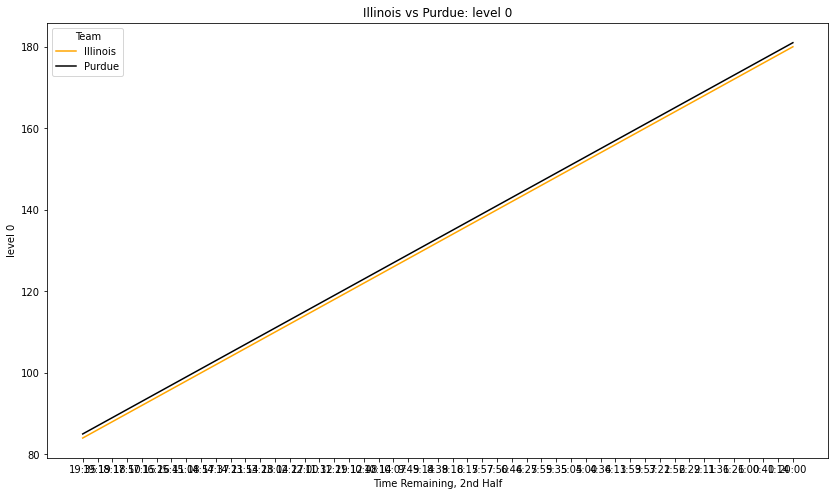

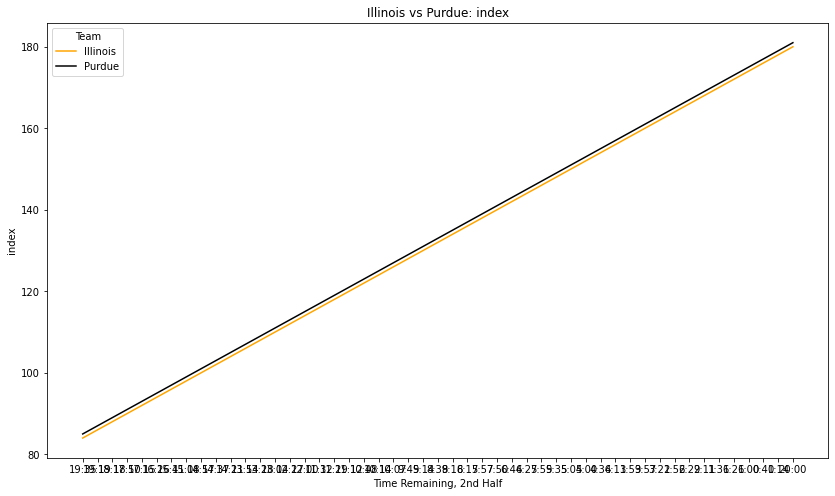

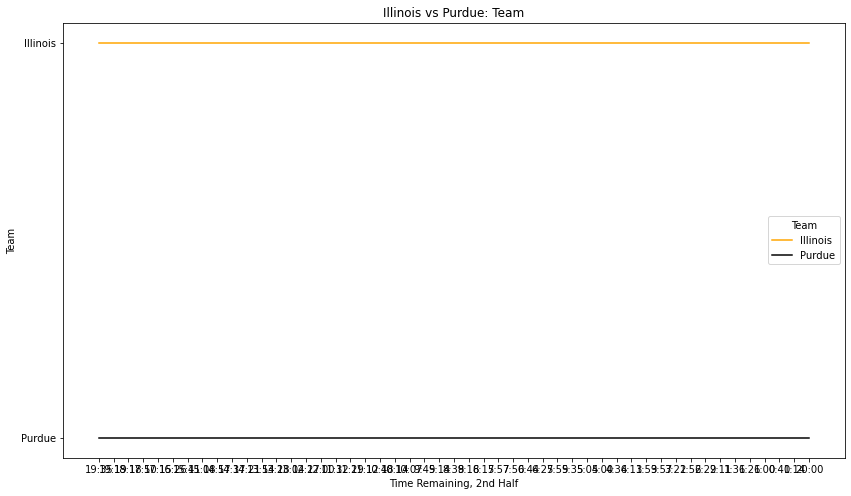

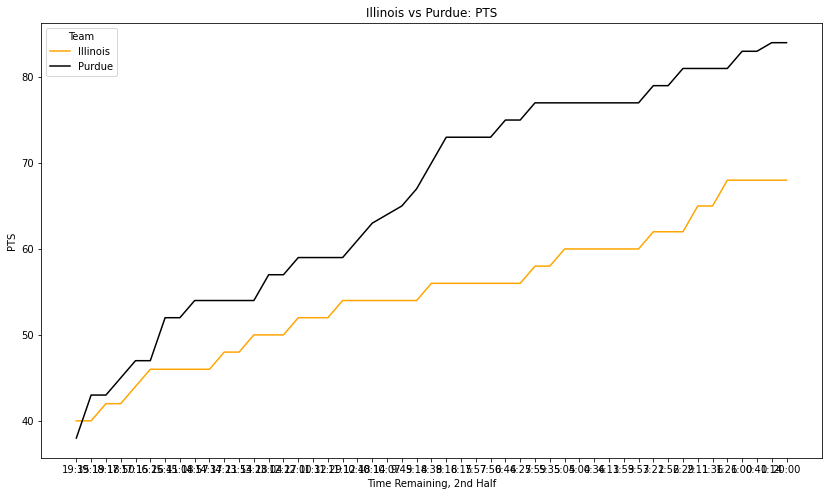

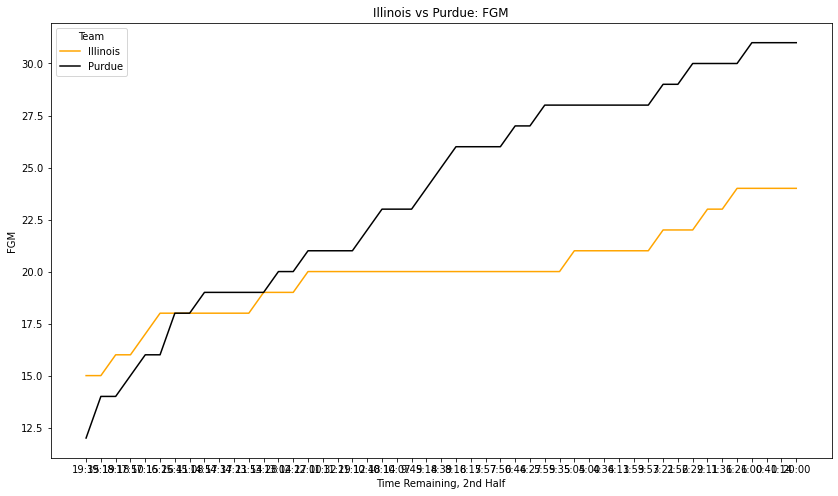

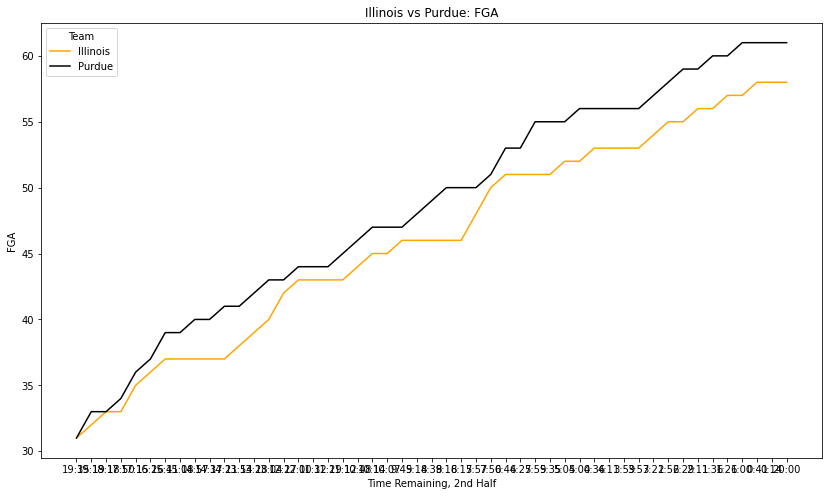

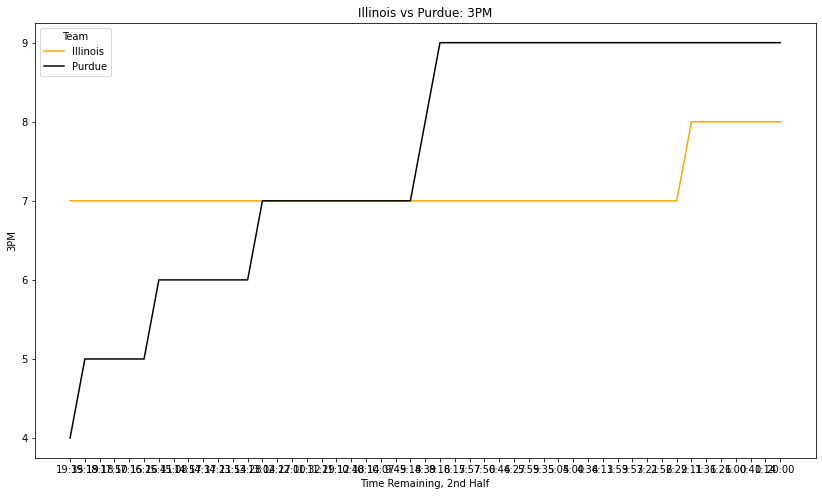

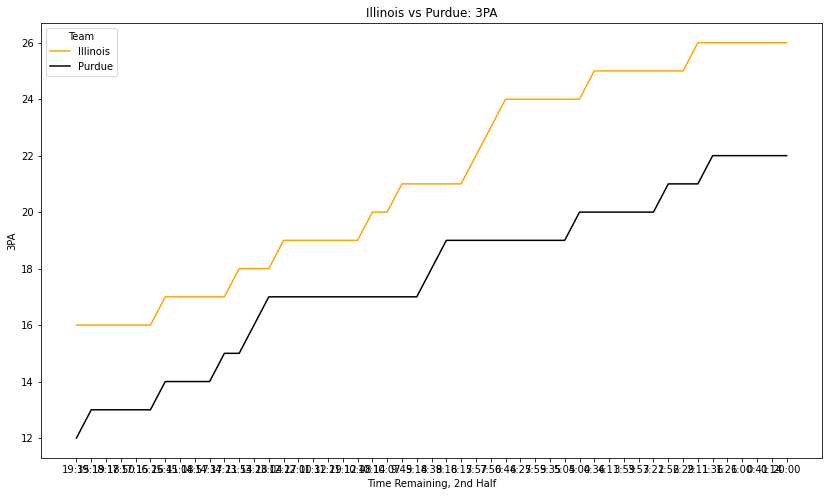

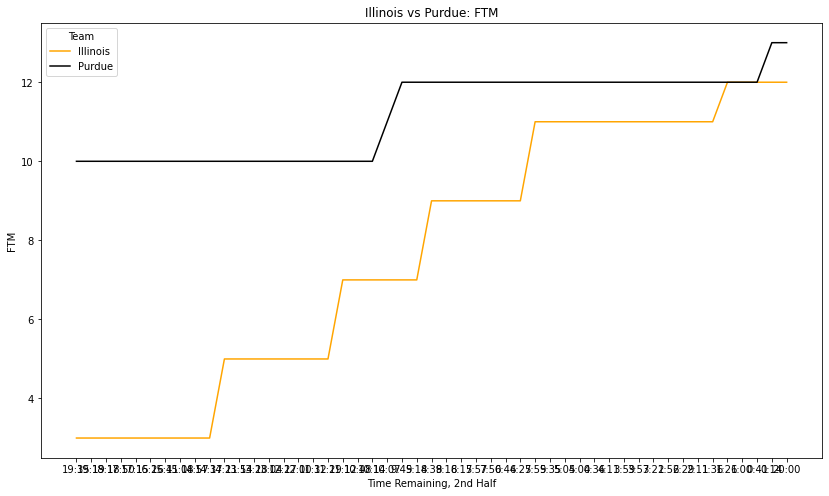

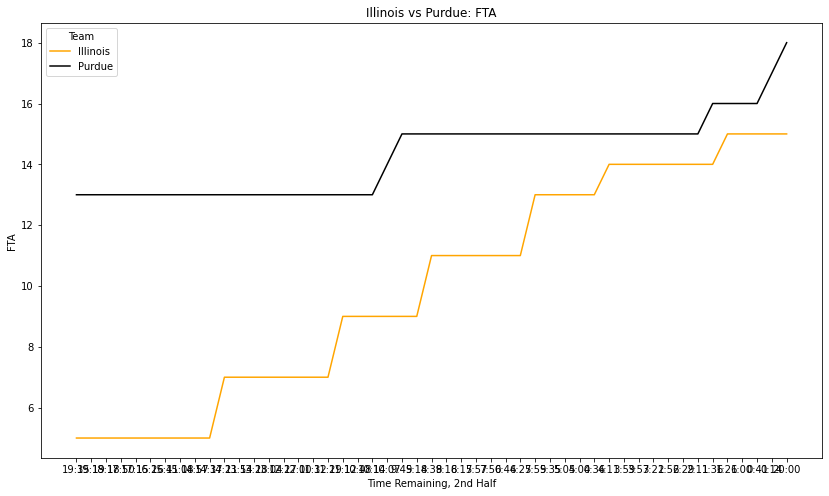

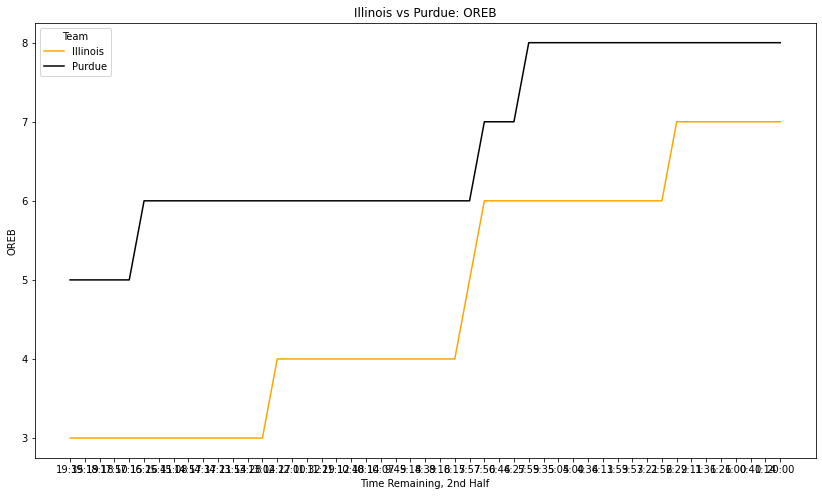

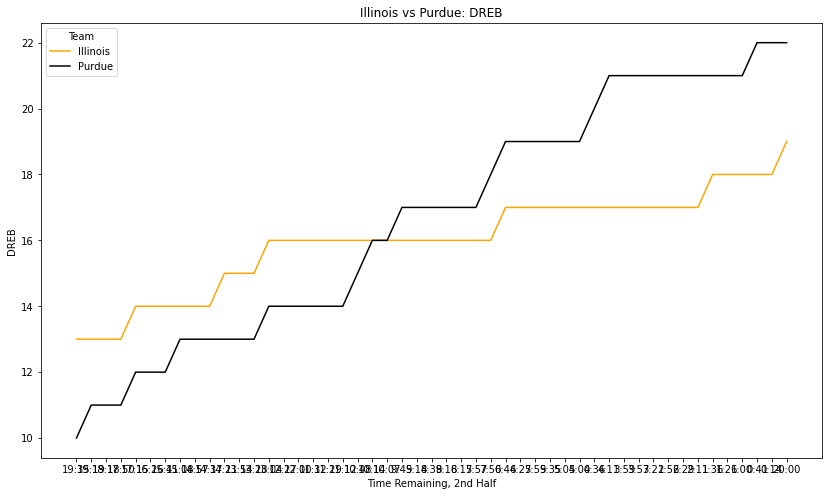

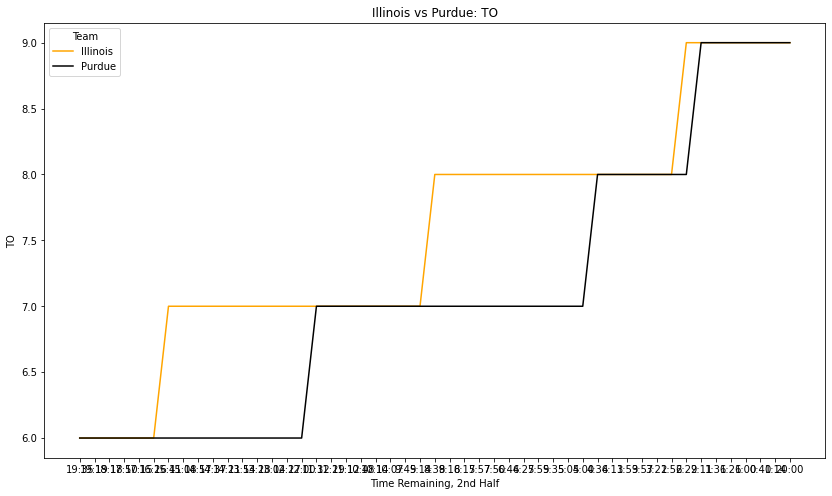

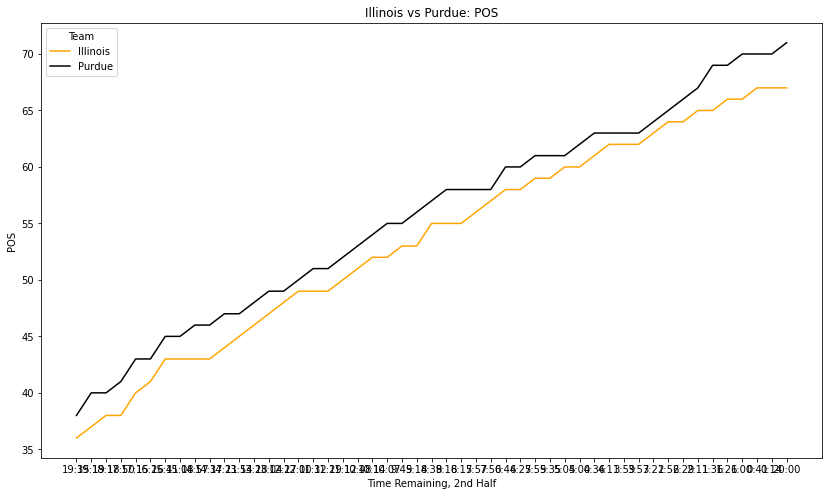

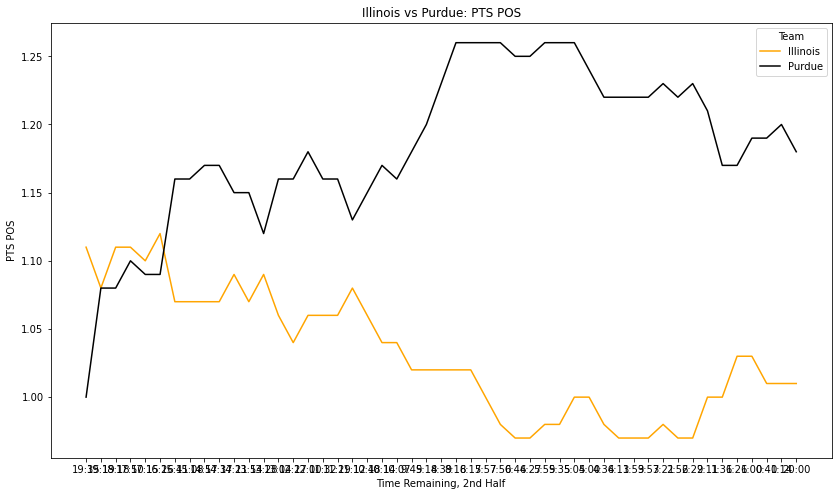

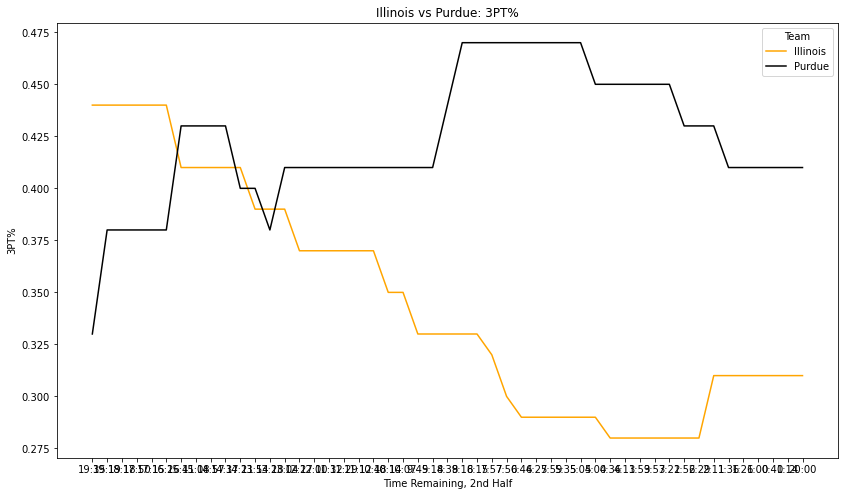

In [59]:
for i in test_df.columns.tolist()[:16]:
  half = 2
  plt.figure(figsize = (14,8))
  sns.lineplot(data = test_df[test_df.Half ==2],
              x = 'Timestamp',
              y = i,
              hue = 'Team',
              palette = ['orange','black'])
  plt.title(f"{test_df.Team.tolist()[0]} vs {test_df.Team.tolist()[1]}: {i.replace('_',' ')}")
  plt.ylabel(i.replace('_',' '))
  plt.xlabel('Time Remaining, 2nd Half')
  if half == 1:
    plt.xlabel('Time Remaining, 1st Half')
  plt.show();

In [6]:
url = "https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/"
game_id = 401364425
url = url + str(game_id)
pd.read_html(url)[1]

,time,team,PLAY,SCORE,Unnamed: 4
0,19:39,NaN,E.J. Liddell missed Three Point Jumper.,0 - 0,NaN
1,19:36,NaN,Donta Scott Defensive Rebound.,0 - 0,NaN
2,19:04,NaN,Qudus Wahab missed Jumper.,0 - 0,NaN
3,18:59,NaN,Zed Key Defensive Rebound.,0 - 0,NaN
4,18:55,NaN,Malaki Branham missed Layup.,0 - 0,NaN
...,...,...,...,...,...
128,0:15,NaN,Malaki Branham missed Jumper.,29 - 42,NaN
129,0:12,NaN,Fatts Russell Defensive Rebound.,29 - 42,NaN
130,0:03,NaN,Fatts Russell missed Layup.,29 - 42,NaN
131,0:00,NaN,E.J. Liddell Defensive Rebound.,29 - 42,NaN
